In [1]:
# use dream_proj_env3
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy.stats import mannwhitneyu, spearmanr, pearsonr, chi2
import numpy as np
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import colorcet as cc
import patsy

source_path = os.path.abspath(os.path.join('..'))
if source_path not in sys.path:
    sys.path.append(os.path.join(source_path, 'source'))
# read source files
# auto reload
%load_ext autoreload
%autoreload 2

import utils
import single_molecule_seq_plotting

# colorpalettes 
hmm = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
fred_again_again_again_palette = ['#000305', '#ff7758', '#f67805', '#d3d3d3', '#565656', '#054fff', '#f9aa74', '#5890ff']
sunset = ['#f3e79b','#fac484','#f8a07e','#eb7f86','#ce6693','#a059a0','#5c53a5']
magma_categorical = plt.cm.get_cmap('magma', 10)
my_continous_palette = sunset
my_categorical_palette = []
my_categorical_palette.append(hmm[3])
my_categorical_palette.append(fred_again_again_again_palette[-2])
my_categorical_palette.append(hmm[-1])
my_categorical_palette.append(fred_again_again_again_palette[-1])

my_categorical_palette.append(hmm[2])
my_categorical_palette.append(sunset[-1])
my_categorical_palette.append(sunset[-2])
my_categorical_palette.append(sunset[-5])
my_categorical_palette.append(sunset[-7])

%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# set global matplotlib font settings
#plt.rcParams['font.family'] = 'arial'
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6
# set distance of ticklabels from axis
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
# set legend title font size
plt.rcParams['legend.title_fontsize'] = 6
# decrease distance between subplots
plt.rcParams['figure.subplot.wspace'] = 0.05
# decrease distance between axes title and ticklabels
plt.rcParams['axes.titlepad'] = .1

from collections import OrderedDict
palette = OrderedDict(
    {
        "C>A": "#03BDEF",
        "C>G": "#010101",
        "C>T": "#E42926",
        "T>A": "#CBCACA",
        "T>C": "#A2CF63",
        "T>G": "#ECC7C5",
    }
)
DIPLOID_MOUSE_GENOME = 5.4e9

fig_dir = os.path.join(REPO_ROOT, "figures/fig_knockout_mice")

/tmp/ipykernel_3400458/1890613209.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  magma_categorical = plt.cm.get_cmap('magma', 10)


In [ ]:
import os
# repo root for relative paths
REPO_ROOT = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))

# Read data

In [2]:
# metadata
sample_type = {
    'S216': 'control',
    'S224': 'control',
    'S226': 'control',
    'S228': 'control',
    'S219': 'control',
    'S214': 'dream_ko',
    'S215': 'dream_ko',
    'S217': 'dream_ko',
    'S221': 'dream_ko',
    'S225': 'dream_ko',
}
age_days ={
    'S216': 637,
    'S224': 630,
    'S226': 651,
    'S228': 645,
    'S219': 595,
    'S214': 588,
    'S215': 612,
    'S217': 653,
    'S221': 638,
    'S225': 603,
}

# read in corrected mutation rate by read group files
data_dir = "../data/alexandrov_collab_2025/dupcaller_output"
burden_fns = glob.glob(os.path.join(data_dir, "S*", "*sbs_burden_by_min_read_group_size.txt"))
burden_dfs = []
for fn in burden_fns:
    df = pd.read_csv(fn, sep="\t", header=0)
    df['sample'] = fn.split("/")[-1].split("_")[0]
    burden_dfs.append(df)
burden_df = pd.concat(burden_dfs)
burden_df['age_days'] = burden_df['sample'].map(age_days)
burden_df['group'] = burden_df['sample'].map(sample_type)
burden_df.reset_index(inplace=True, drop=True)

# read in stats files
stats_fns = glob.glob(os.path.join(data_dir, "S*", "*_stats.txt"))
stats_fns = [fn for fn in stats_fns if "group" not in fn]
stats_dfs = []
for fn in stats_fns:
    df = pd.read_csv(fn, sep="\t", header=None).T
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df['sample'] = fn.split("/")[-1].split("_")[0]
    stats_dfs.append(df)
stats_df = pd.concat(stats_dfs)
burden_stats_df = burden_df.merge(stats_df, on='sample', how='left')

# and read in sbs_96_corrected.txt files
sbs_fns = glob.glob(os.path.join(data_dir, "S*", "*sbs_96_corrected.txt"))
sbs_dfs = []
for fn in sbs_fns:
    df = pd.read_csv(fn, sep="\t", header=None)
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df['sample'] = fn.split("/")[-1].split("_")[0]
    # name first column "sbs"
    df.columns = ["sbs"] + df.columns[1:].tolist()
    sbs_dfs.append(df)
sbs_df = pd.concat(sbs_dfs)
sbs_df['number'] = sbs_df['number'].astype(int)
sbs_df.reset_index(inplace=True, drop=True)
sbs_df['is_ct'] = sbs_df['sbs'].str.contains('C>T')
sbs_muts = sbs_df.groupby('sample')['number'].sum()
sbs_muts_no_ct = sbs_df.query("is_ct == False").groupby('sample')['number'].sum()
burden_stats_df['sbs_mut'] =burden_stats_df['sample'].map(sbs_muts)
burden_stats_df['sbs_mut_no_ct'] =burden_stats_df['sample'].map(sbs_muts_no_ct)

# read in result of ffpesig
corrected_sbs_df = pd.read_csv("../data/alexandrov_collab_2025/FFPEsig/FFPEsig_OUTPUT/corrected_sbs_df.csv", index_col=0)
corrected_sbs_muts = corrected_sbs_df.sum()
corrected_sbs_muts_no_ct = corrected_sbs_df.loc[(~ corrected_sbs_df.index.str.contains('C>T')) & (~ corrected_sbs_df.index.str.contains('G>A'))].sum()
burden_stats_df['ffpesig_sbs_mut'] =burden_stats_df['sample'].map(corrected_sbs_muts)
burden_stats_df['ffpesig_sbs_mut_no_ct'] =burden_stats_df['sample'].map(corrected_sbs_muts_no_ct)

# subset to important columns
mutation_df = burden_stats_df[['age_days', 'group','sample','read number','Effective Coverage', 'Corrected_burden', 'Uncorrrected_burden','Number of Effective Read Families', 'sbs_mut', 'sbs_mut_no_ct', 'ffpesig_sbs_mut', 'ffpesig_sbs_mut_no_ct']].copy(deep = True)
mutation_df[['age_days', 'read number','Effective Coverage', 'Corrected_burden', 'Uncorrrected_burden','Number of Effective Read Families', 'sbs_mut', 'sbs_mut_no_ct', 'ffpesig_sbs_mut', 'ffpesig_sbs_mut_no_ct']] = mutation_df[['age_days', 'read number','Effective Coverage', 'Corrected_burden', 'Uncorrrected_burden','Number of Effective Read Families', 'sbs_mut', 'sbs_mut_no_ct', 'ffpesig_sbs_mut', 'ffpesig_sbs_mut_no_ct']].astype(float)
# rename all columns to lowercase and replace spaces with underscores
mutation_df.columns = mutation_df.columns.str.lower().str.replace(' ', '_')

# put variables on common scale
mutation_df['age_months'] = mutation_df['age_days'] / 30.436875
mutation_df['eff_coverage_tens_of_mbs'] = mutation_df['effective_coverage'] / 1e7
mutation_df['n_effective_rf_millions'] = mutation_df['number_of_effective_read_families'] / 1e6
mutation_df.query("read_number == 1", inplace=True)

# Indels

In [20]:
# read in id activities
id_activity_fn = os.path.join(REPO_ROOT, "data/alexandrov_collab_2025/dupcaller_output/vcfs/combined_vcfs/output/id_signatures/ID83/Suggested_Solution/COSMIC_ID83_Decomposed_Solution/Activities/COSMIC_ID83_Activities.txt")
id_activity_df = pd.read_csv(id_activity_fn, sep='\t')
id_activity_df.rename(columns={'Samples': 'sample'}, inplace=True)
id_activity_df['sample'] = id_activity_df['sample'].str.replace('_combined', '')

id_activity_df = id_activity_df.merge(mutation_df[['sample', 'group', 'age_months', 'eff_coverage_tens_of_mbs', 'n_effective_rf_millions']], on='sample', how='left').drop_duplicates()

id_color_map = {
        'ID1': cc.glasbey[11],
    'ID8': cc.glasbey[12],
    'ID9': cc.glasbey[13],
    'ID21': cc.glasbey[14],
    'ID23': cc.glasbey[15],
}
id_mut_cols = ['ID1', 'ID8', 'ID9', 'ID21', 'ID23']

control vs. dream_ko: Custom statistical test, P_val:2.913e-06


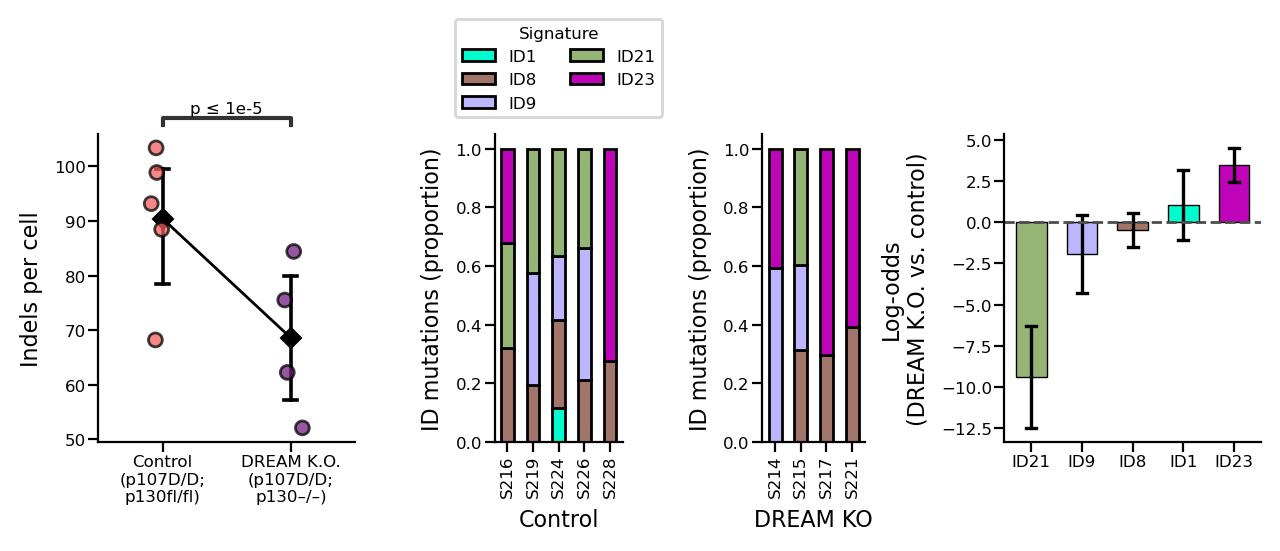

In [21]:
# 3 plots next to each other
fig, ax = plt.subplots(1, 4, figsize=(7.5, 2), gridspec_kw={'width_ratios': [1,  .5, .4, 1], 'wspace': 0.75})

id_activity_df['total_mutations'] = id_activity_df[id_mut_cols].sum(axis=1)
mut_col  = 'total_mutations'
group_col = 'group'
sample_col = 'sample'
cov_col = 'eff_coverage_tens_of_mbs'
fam_col = 'n_effective_rf_millions'
formula = "total_mutations ~ age_months + group + n_effective_rf_millions * eff_coverage_tens_of_mbs"
offset_col = None
exclude_samples = None
ylabel = 'Indels per cell'
group_order = ['control', 'dream_ko']
plot_predicted = True
magma = plt.colormaps['magma']
palette = {
    'dream_ko': magma(3.33/10), 
    'control': magma(6.66/10)
}

# fit the model
model, plot_df = single_molecule_seq_plotting.fit_mutation_burden_model(
    df=id_activity_df.query("sample != 'S225'"), mut_col=mut_col,
    group_col=group_col, sample_col=sample_col, cov_col=cov_col, fam_col=fam_col,
    formula=formula, offset_col=offset_col, exclude_samples=exclude_samples
)

# create pointplot
fig, _, plot_df = single_molecule_seq_plotting.plot_mutation_burden(
    model=model, plot_df=plot_df, mut_col=mut_col, group_col=group_col,
    ylabel=ylabel, group_order=group_order, plot_predicted=plot_predicted,
    palette=palette,ax=ax[0]
)

# plot signature activities
fig, _ = single_molecule_seq_plotting.plot_signature_activities(id_activity_df.query("sample != 'S225'"), signature_type='ID mutations', colors = id_color_map, mut_cols = id_mut_cols, fig = fig, axes = ax[1:3], normalize=True)


formula_template = (
    "{prop_col} ~ C(group, Treatment(reference='control'))"
    " + n_effective_rf_millions * eff_coverage_tens_of_mbs"
)

fig, ax, group_df = single_molecule_seq_plotting.plot_group_coefficients(
    id_activity_df, 
    id_mut_cols, 
    formula_template, 
    color_map=id_color_map,
    fig = fig, ax = ax[3]
)

# save to svg
fig.savefig(os.path.join(fig_dir, "indels.svg"), bbox_inches='tight', dpi=300, transparent=True, format='svg')

In [175]:
np.exp(-0.2177)

0.8043667154883233

In [174]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        total_mutations   No. Observations:                    9
Model:                            GLM   Df Residuals:                        3
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32.567
Date:                Mon, 11 Aug 2025   Deviance:                       2.9968
Time:                        14:34:02   Pearson chi2:                     2.98
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9719
Covariance Type:                  HC0                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            6.4794      0.947      6.843      0.000       4.624       8.335
group[T.dream_ko]                                   -0.2177      0.047     -4.677      0.000      -0.309      -0.126
age_months                                           0.2262      0.039      5.848      0.000       0.150       0.302
n_effective_rf_millions                             -0.0887      0.018     -4.963      0.000      -0.124      -0.054
eff_coverage_tens_of_mbs                            -0.0219      0.003     -6.737      0.000      -0.028      -0.016
n_effective_rf_millions:eff_coverage_tens_of_mbs     0.0003   4.69e-05      6.683      0.000       0.000       0.000
====================================================================================================================
"""

In [40]:
group_df

,mut_col,coef,pvalue,lo,hi
0,ID21,-9.388279,2.719360e-09,-12.482027,-6.294530
1,ID9,-1.937699,1.090210e-01,-4.307473,0.432074
2,ID8,-0.488669,3.567844e-01,-1.528023,0.550684
3,ID1,1.046659,3.379000e-01,-1.093970,3.187289
4,ID23,3.459639,1.017179e-10,2.410695,4.508583


# SBS

In [9]:
# read in signature activities
sbs_activity_fn = os.path.join(REPO_ROOT, "data/alexandrov_collab_2025/output_SigProfilerAssignment/cosmic_fit_results_only_extracted/Assignment_Solution/Activities/Assignment_Solution_Activities.txt")
sbs_activity_df = pd.read_csv(sbs_activity_fn, sep='\t')
sbs_activity_df.rename(columns={'Samples': 'sample'}, inplace=True)
sbs_activity_df['sample'] = sbs_activity_df['sample'].str.replace('_snv', '')
sbs_activity_df = sbs_activity_df.merge(mutation_df[['sample', 'group', 'age_months', 'eff_coverage_tens_of_mbs', 'n_effective_rf_millions']], on='sample', how='left').drop_duplicates()
# drop columns that are all 0
sbs_activity_df = sbs_activity_df.loc[:, (sbs_activity_df != 0).any(axis=0)]
sbs_activity_df.rename(columns={'ffpe_sig_repaired': 'FFPE'}, inplace=True)
sbs_color_map = {
    'SBS1': cc.glasbey_cool[2],
    'SBS10b': cc.glasbey_cool[5],
    'SBS30': cc.glasbey_cool[4],
    'SBS5': cc.glasbey_cool[6],
    'SBS87': cc.glasbey_cool[7],
    'SBS2': cc.glasbey_cool[8],
    'SBS32': cc.glasbey_cool[9],
    'SBS97': cc.glasbey_cool[10],
    'FFPE':'red'
}
sbs_mut_cols = ['SBS1','SBS5', 'SBS30', 'FFPE']
sbs_activity_df['total_mutations'] = sbs_activity_df[[x for x in sbs_mut_cols if x != 'FFPE']].sum(axis=1)

control vs. dream_ko: Custom statistical test, P_val:1.598e-09


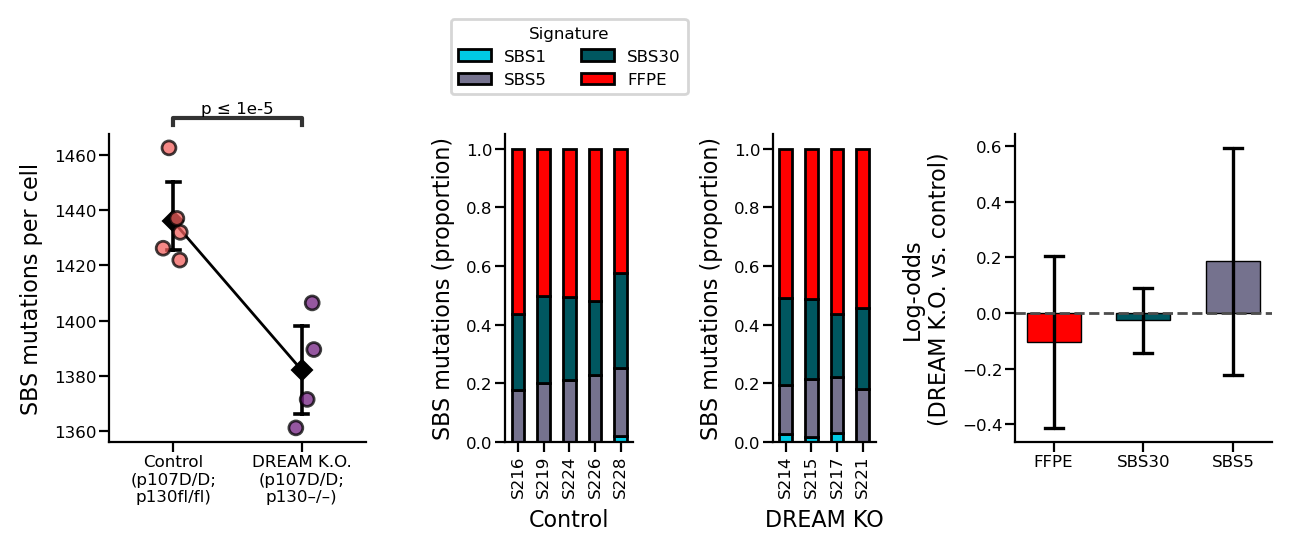

In [10]:
# 3 plots next to each other
fig, ax = plt.subplots(1, 4, figsize=(7.5, 2), gridspec_kw={'width_ratios': [1,  .5, .4, 1], 'wspace': 0.75})

mut_col  = 'total_mutations'
group_col = 'group'
sample_col = 'sample'
cov_col = 'eff_coverage_tens_of_mbs'
fam_col = 'n_effective_rf_millions'
formula = "total_mutations ~ age_months + group + n_effective_rf_millions * eff_coverage_tens_of_mbs"
offset_col = None
exclude_samples = None
ylabel = 'SBS mutations per cell'
group_order = ['control', 'dream_ko']
plot_predicted = True
magma = plt.colormaps['magma']
palette = {
    'dream_ko': magma(3.33/10), 
    'control': magma(6.66/10)
}

# fit the model
model, plot_df = single_molecule_seq_plotting.fit_mutation_burden_model(
    df=sbs_activity_df.query("sample != 'S225'"), mut_col=mut_col,
    group_col=group_col, sample_col=sample_col, cov_col=cov_col, fam_col=fam_col,
    formula=formula, offset_col=offset_col, exclude_samples=exclude_samples
)

# create pointplot
fig, _, plot_df = single_molecule_seq_plotting.plot_mutation_burden(
    model=model, plot_df=plot_df, mut_col=mut_col, group_col=group_col,
    ylabel=ylabel, group_order=group_order, plot_predicted=plot_predicted,
    palette=palette,ax=ax[0]
)

# plot signature activities
fig, _ = single_molecule_seq_plotting.plot_signature_activities(
    sbs_activity_df.query("sample != 'S225'"), signature_type='SBS mutations', 
    colors = sbs_color_map, mut_cols = sbs_mut_cols, fig = fig, axes = ax[1:3], normalize=True
    )


formula_template = (
    "{prop_col} ~ C(group, Treatment(reference='control'))"
    " + eff_coverage_tens_of_mbs * n_effective_rf_millions"
)

fig, ax, group_df = single_molecule_seq_plotting.plot_group_coefficients(
    sbs_activity_df, 
    [x for x in sbs_mut_cols if x not in ['SBS1']], 
    formula_template, 
    color_map=sbs_color_map,
    fig = fig, ax = ax[3],
)
fig.savefig(os.path.join(fig_dir, "sbs.svg"), bbox_inches='tight', dpi=300, transparent=True, format='svg')

In [18]:
model.pvalues

Intercept                                            0.000000e+00
group[T.dream_ko]                                    1.598366e-09
age_months                                           6.980487e-05
n_effective_rf_millions                             1.079434e-267
eff_coverage_tens_of_mbs                             0.000000e+00
n_effective_rf_millions:eff_coverage_tens_of_mbs     0.000000e+00
dtype: float64

In [ ]:
np.exp(-0.0426)

0.9582946312661874

In [12]:
plot_df

,sample,SBS1,SBS5,SBS30,FFPE,group,age_months,eff_coverage_tens_of_mbs,n_effective_rf_millions,total_mutations,predicted_muts
0,S214,59,390,687,1185,dream_ko,19.318672,540.0,64.042277,1136,1406.409241
1,S215,42,446,626,1180,dream_ko,20.107189,540.0,64.042277,1114,1389.554876
2,S216,0,501,729,1586,control,20.928561,540.0,64.042277,1230,1431.932524
3,S217,73,483,537,1406,dream_ko,21.454239,540.0,64.042277,1093,1361.227938
4,S219,0,552,813,1379,control,19.548656,540.0,64.042277,1365,1462.465295
5,S221,0,549,857,1663,dream_ko,20.961416,540.0,64.042277,1406,1371.523836
6,S224,0,592,796,1425,control,20.698577,540.0,64.042277,1388,1436.976688
8,S226,0,562,628,1284,control,21.388530,540.0,64.042277,1190,1421.897252
9,S228,41,466,655,855,control,21.191400,540.0,64.042277,1162,1426.189442


# Supplementary: model selection

In [27]:
def likelihood_ratio_test(model_full, model_reduced):
    # Likelihood ratio statistic
    lr_stat = 2 * (model_full.llf - model_reduced.llf)
    df_diff = model_full.df_model - model_reduced.df_model
    p_value = chi2.sf(lr_stat, df_diff)
    print(f"LR statistic: {lr_stat:.3f}, df: {df_diff}, p-value: {p_value:.4g}")

### Indel

LR statistic: 10.724, df: 1, p-value: 0.001058
	-> use model 3 over model 2
LR statistic: 12.501, df: 2, p-value: 0.00193
	-> use model 3 over model 1
LR statistic: 1.777, df: 1, p-value: 0.1825
	-> use model 2 over model 1


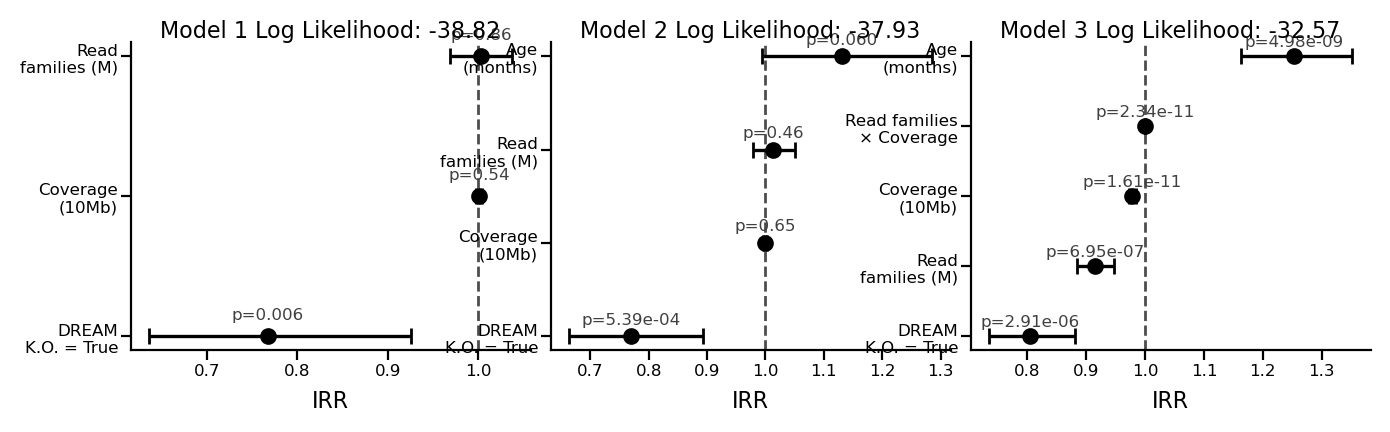

In [29]:
mut_col  = 'total_mutations'
group_col = 'group'
sample_col = 'sample'
cov_col = 'eff_coverage_tens_of_mbs'
fam_col = 'n_effective_rf_millions'
offset_col = None
exclude_samples = None

# create 7 plots in a grid
fig, ax= plt.subplots(1, 3, figsize=(8, 2))
ax = ax.flatten()

log_likelihoods = {}

# model 1
model1, plot_df = single_molecule_seq_plotting.fit_mutation_burden_model(
    formula="total_mutations ~  group + n_effective_rf_millions + eff_coverage_tens_of_mbs",
    df=id_activity_df.query("sample != 'S225'"), mut_col=mut_col,
    group_col=group_col, sample_col=sample_col, cov_col=cov_col, fam_col=fam_col,
     offset_col=offset_col, exclude_samples=exclude_samples
)
log_likelihoods['model1'] = model1.llf
fig, _, coef_df = single_molecule_seq_plotting.plot_model_coefficients(
    model1, exponentiate=True, color = 'black', ax = ax[0]
    )
ax[0].set_title(f"Model 1 Log Likelihood: {model1.llf:.2f}", fontsize=8)

# model 2
model2, plot_df = single_molecule_seq_plotting.fit_mutation_burden_model(
    formula="total_mutations ~ age_months + group + n_effective_rf_millions + eff_coverage_tens_of_mbs",
    df=id_activity_df.query("sample != 'S225'"), mut_col=mut_col,
    group_col=group_col, sample_col=sample_col, cov_col=cov_col, fam_col=fam_col,
     offset_col=offset_col, exclude_samples=exclude_samples
)
log_likelihoods['model2'] = model2.llf
fig, _, coef_df = single_molecule_seq_plotting.plot_model_coefficients(
    model2, exponentiate=True, color = 'black', ax = ax[1]
    )
ax[1].set_title(f"Model 2 Log Likelihood: {model2.llf:.2f}", fontsize=8)

# model 3
model3, plot_df = single_molecule_seq_plotting.fit_mutation_burden_model(
    formula="total_mutations ~ age_months + group + n_effective_rf_millions * eff_coverage_tens_of_mbs",
    df=id_activity_df.query("sample != 'S225'"), mut_col=mut_col,
    group_col=group_col, sample_col=sample_col, cov_col=cov_col, fam_col=fam_col,
     offset_col=offset_col, exclude_samples=exclude_samples
)
log_likelihoods['model3'] = model3.llf
fig, _, coef_df = single_molecule_seq_plotting.plot_model_coefficients(
    model3, exponentiate=True, color = 'black', ax = ax[2]
    )
ax[2].set_title(f"Model 3 Log Likelihood: {model3.llf:.2f}", fontsize=8)

likelihood_ratio_test(model3, model2)
print("\t-> use model 3 over model 2")

likelihood_ratio_test(model3, model1)
print("\t-> use model 3 over model 1")

likelihood_ratio_test(model2, model1)
print("\t-> use model 2 over model 1")


fig.savefig(os.path.join(os.path.join(REPO_ROOT, "figures/supplementary/supp_knockout_mice"), "indel_models.svg"), bbox_inches='tight', dpi=300, transparent=True, format='svg')


### SBS

LR statistic: 25.453, df: 1, p-value: 4.533e-07
	-> use model 3 over model 2
LR statistic: 27.395, df: 2, p-value: 1.125e-06
	-> use model 3 over model 1
LR statistic: 1.942, df: 1, p-value: 0.1635
	-> use model 2 over model 1


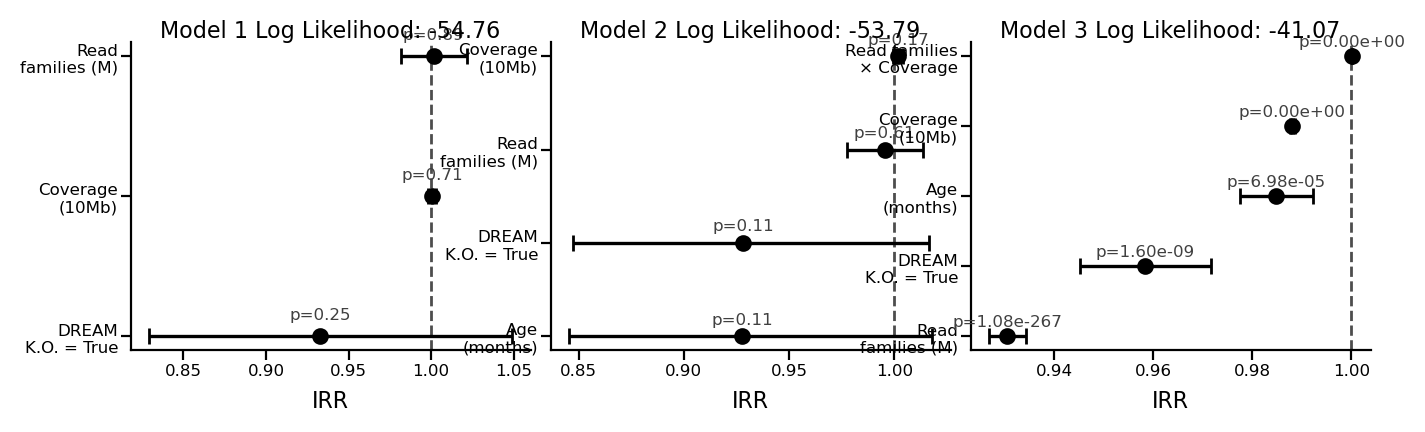

In [30]:
mut_col  = 'total_mutations'
group_col = 'group'
sample_col = 'sample'
cov_col = 'eff_coverage_tens_of_mbs'
fam_col = 'n_effective_rf_millions'
offset_col = None
exclude_samples = None


# create 7 plots in a grid
fig, ax= plt.subplots(1, 3, figsize=(8, 2))
ax = ax.flatten()

log_likelihoods = {}

# model 1
model1, plot_df = single_molecule_seq_plotting.fit_mutation_burden_model(
    formula="total_mutations ~  group + n_effective_rf_millions + eff_coverage_tens_of_mbs",
    df=sbs_activity_df.query("sample != 'S225'"), mut_col=mut_col,
    group_col=group_col, sample_col=sample_col, cov_col=cov_col, fam_col=fam_col,
     offset_col=offset_col, exclude_samples=exclude_samples
)
log_likelihoods['model1'] = model1.llf
fig, _, coef_df = single_molecule_seq_plotting.plot_model_coefficients(
    model1, exponentiate=True, color = 'black', ax = ax[0]
    )
ax[0].set_title(f"Model 1 Log Likelihood: {model1.llf:.2f}", fontsize=8)

# model 2
model2, plot_df = single_molecule_seq_plotting.fit_mutation_burden_model(
    formula="total_mutations ~ age_months + group + n_effective_rf_millions + eff_coverage_tens_of_mbs",
    df=sbs_activity_df.query("sample != 'S225'"), mut_col=mut_col,
    group_col=group_col, sample_col=sample_col, cov_col=cov_col, fam_col=fam_col,
     offset_col=offset_col, exclude_samples=exclude_samples
)
log_likelihoods['model2'] = model2.llf
fig, _, coef_df = single_molecule_seq_plotting.plot_model_coefficients(
    model2, exponentiate=True, color = 'black', ax = ax[1]
    )
ax[1].set_title(f"Model 2 Log Likelihood: {model2.llf:.2f}", fontsize=8)

# model 3
model3, plot_df = single_molecule_seq_plotting.fit_mutation_burden_model(
    formula="total_mutations ~ age_months + group + n_effective_rf_millions * eff_coverage_tens_of_mbs",
    df=sbs_activity_df.query("sample != 'S225'"), mut_col=mut_col,
    group_col=group_col, sample_col=sample_col, cov_col=cov_col, fam_col=fam_col,
     offset_col=offset_col, exclude_samples=exclude_samples
)
log_likelihoods['model3'] = model3.llf
fig, _, coef_df = single_molecule_seq_plotting.plot_model_coefficients(
    model3, exponentiate=True, color = 'black', ax = ax[2]
    )
ax[2].set_title(f"Model 3 Log Likelihood: {model3.llf:.2f}", fontsize=8)

likelihood_ratio_test(model3, model2)
print("\t-> use model 3 over model 2")

likelihood_ratio_test(model3, model1)
print("\t-> use model 3 over model 1")

likelihood_ratio_test(model2, model1)
print("\t-> use model 2 over model 1")

fig.savefig(os.path.join(os.path.join(REPO_ROOT, "figures/supplementary/supp_knockout_mice"), "sbs_models.svg"), bbox_inches='tight', dpi=300, transparent=True, format='svg')


# Supp: outlier

In [22]:
mut_col  = 'total_mutations'
group_col = 'group'
sample_col = 'sample'
cov_col = 'eff_coverage_tens_of_mbs'
fam_col = 'n_effective_rf_millions'
formula = "total_mutations ~ age_months + group + n_effective_rf_millions * eff_coverage_tens_of_mbs"
offset_col = None
exclude_samples = None
ylabel = 'SBS mutations per cell'
group_order = ['control', 'dream_ko']
plot_predicted = True
magma = plt.colormaps['magma']
palette = {
    'dream_ko': magma(3.33/10), 
    'control': magma(6.66/10)
}

# fit the model
model, plot_df = single_molecule_seq_plotting.fit_mutation_burden_model(
    df=sbs_activity_df, mut_col=mut_col,
    group_col=group_col, sample_col=sample_col, cov_col=cov_col, fam_col=fam_col,
    formula=formula, offset_col=offset_col, exclude_samples=exclude_samples
)
sbs_outlier_df = single_molecule_seq_plotting.detect_model_outliers(
    model, data=plot_df, sample_col='sample'
    )


In [23]:
id_activity_df['total_mutations'] = id_activity_df[id_mut_cols].sum(axis=1)
mut_col  = 'total_mutations'
group_col = 'group'
sample_col = 'sample'
cov_col = 'eff_coverage_tens_of_mbs'
fam_col = 'n_effective_rf_millions'
formula = "total_mutations ~ age_months + group + n_effective_rf_millions * eff_coverage_tens_of_mbs"
offset_col = None
exclude_samples = None
ylabel = 'Indels per cell'
group_order = ['control', 'dream_ko']
plot_predicted = True
magma = plt.colormaps['magma']
palette = {
    'dream_ko': magma(3.33/10), 
    'control': magma(6.66/10)
}

# fit the model
model, plot_df = single_molecule_seq_plotting.fit_mutation_burden_model(
    df=id_activity_df, mut_col=mut_col,
    group_col=group_col, sample_col=sample_col, cov_col=cov_col, fam_col=fam_col,
    formula=formula, offset_col=offset_col, exclude_samples=exclude_samples
)


id_outlier_df = single_molecule_seq_plotting.detect_model_outliers(
    model, data=plot_df, sample_col='sample'
    )

In [24]:
def pivot_outlier_metrics(outlier_df):
    """
    pivot outlier DataFrame to long format with sample, metric, and value columns
    
    Parameters:
    -----------
    outlier_df : pd.DataFrame
        output from detect_model_outliers function
        
    Returns:
    --------
    pd.DataFrame
        long-format DataFrame with columns: sample, metric, value, flag, threshold
    """
    import pandas as pd
    import numpy as np
    
    # define the metrics we want to pivot
    metrics = {
        'cooks_d': {
            'value_col': 'cooks_d',
            'flag_col': 'flag_cooks_d',
            'threshold_col': 'threshold_cooks_d'
        },
        'zscore_all': {
            'value_col': 'zscore_all',
            'flag_col': 'flag_zscore_all',
            'threshold_col': None  # threshold is constant (zscore_threshold)
        },
        'total_mutations': {
            'value_col': 'total_mutations',
            'flag_col': None,  # no flag column for raw total mutations
            'threshold_col': None
        }
    }
    
    # get sample column if available
    sample_col = 'sample' if 'sample' in outlier_df.columns else outlier_df.index.name or 'sample'
    
    pivot_rows = []
    for idx, row in outlier_df.iterrows():
        sample_id = row.get('sample', idx)
        
        for metric_name, metric_info in metrics.items():
            value_col = metric_info['value_col']
            flag_col = metric_info['flag_col']
            threshold_col = metric_info['threshold_col']
            
            # skip if value column doesn't exist
            if value_col not in outlier_df.columns:
                continue
                
            value = row[value_col]
            
            # get flag (optional)
            if flag_col and flag_col in outlier_df.columns:
                flag = row[flag_col]
            else:
                flag = np.nan  # or False, depending on preference
            
            # get threshold
            if threshold_col and threshold_col in outlier_df.columns:
                threshold = row[threshold_col]
            elif 'zscore' in metric_name:
                # for z-score metrics, threshold is typically 3.0
                threshold = 3.0
            else:
                threshold = np.nan
            
            pivot_rows.append({
                'sample': sample_id,
                'metric': metric_name,
                'value': value,
                'flag': flag,
                'threshold': threshold
            })
    
    pivot_df = pd.DataFrame(pivot_rows)
    return pivot_df

id_pivot = pivot_outlier_metrics(id_outlier_df)
id_pivot['mutation_type'] = 'Indel'

sbs_pivot = pivot_outlier_metrics(sbs_outlier_df)
sbs_pivot['mutation_type'] = 'SBS'

pivot_df = pd.concat([id_pivot, sbs_pivot])


/tmp/ipykernel_3400458/2643487612.py:3: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  stripplot1 = sns.stripplot(
/tmp/ipykernel_3400458/2643487612.py:7: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  stripplot2 = sns.stripplot(
/tmp/ipykernel_3400458/2643487612.py:11: UserWarning: The palette list has more values (256) than needed (2), which may not be intended.
  stripplot3 = sns.stripplot(


total_mutations
zscore_all
cooks_d


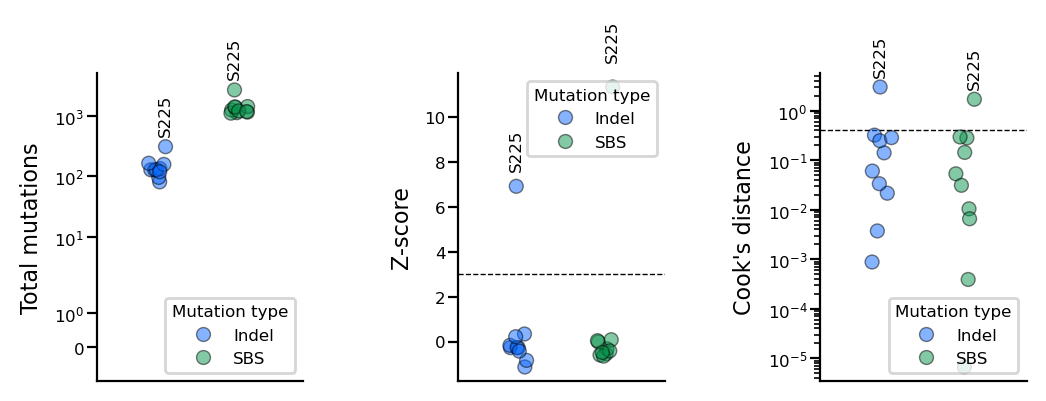

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(6, 2), gridspec_kw={'wspace': 0.75})

stripplot1 = sns.stripplot(
    data=pivot_df.query("metric == 'total_mutations'"), hue='mutation_type', y='value', x='metric', dodge=True, ax=ax[0], alpha=0.5, edgecolor='black',linewidth=.5,
    palette=cc.glasbey_cool,
    )
stripplot2 = sns.stripplot(
    data=pivot_df.query("metric == 'zscore_all'"), hue='mutation_type', y='value', x='metric', dodge=True, ax=ax[1], alpha=0.5, edgecolor='black',linewidth=.5,
    palette=cc.glasbey_cool,
    )
stripplot3 = sns.stripplot(
    data=pivot_df.query("metric == 'cooks_d'"), hue='mutation_type', y='value', x='metric', dodge=True, ax=ax[2], alpha=0.5, edgecolor='black',linewidth=.5,
    palette=cc.glasbey_cool,
    )

# label points on the first plot (zscore_all)
for stripplot, metric_name in zip([stripplot1, stripplot2, stripplot3], ['total_mutations', 'zscore_all', 'cooks_d']):
    print(metric_name)
    for collection in stripplot.collections:
        offsets = collection.get_offsets()
        if len(offsets) > 0:
            # get the positions of the points from the stripplot
            for i, (x_pos, y_pos) in enumerate(offsets):
                # find the corresponding data point
                subset = pivot_df.query(f"metric == '{metric_name}'").copy()
                
                # find the point that matches this y value and metric
                matches = subset[abs(subset['value'] - y_pos) < 0.01]
                if len(matches) > 0:
                    # only label if this is the maximum value for this mutation_type
                    mutation_type = matches.iloc[0]['mutation_type']
                    max_value = subset[subset['mutation_type'] == mutation_type]['value'].max()
                    if abs(y_pos - max_value) < 0.01:  # this is the max point
                        sample_name = matches.iloc[0]['sample']
                        if metric_name == 'total_mutations':
                            ax[0].text(x_pos, y_pos + (y_pos*0.5), sample_name, ha='center', va='bottom', fontsize=6, color='black',  rotation=90)
                        elif metric_name == 'zscore_all':
                            ax[1].text(x_pos, y_pos + (y_pos*0.1), sample_name, ha='center', va='bottom', fontsize=6, color='black', rotation=90)
                        elif metric_name == 'cooks_d':
                            ax[2].text(x_pos, y_pos + (y_pos*0.6), sample_name, ha='center', va='bottom', fontsize=6, color='black', rotation=90)


# add threshold lines
ax[1].axhline(y=3, color='black', linestyle='--', linewidth=0.5)
ax[2].axhline(y=0.4, color='black', linestyle='--', linewidth=0.5)

sns.despine(ax=ax[0])
sns.despine(ax=ax[1])
sns.despine(ax=ax[2])

# remove x tick and axis labels
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].set_xticklabels([])
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[0].set_ylabel('Total mutations')
ax[1].set_ylabel('Z-score')
ax[2].set_ylabel('Cook\'s distance')

# add legend
ax[0].legend(title='Mutation type', loc='lower right', fontsize=6)
ax[1].legend(title='Mutation type', loc='upper right', fontsize=6)
ax[2].legend(title='Mutation type', loc='lower right', fontsize=6)

ax[0].set_yscale('symlog')
ax[0].set_ylim(-1, 5000)
ax[2].set_yscale('log')

fig.savefig(os.path.join(os.path.join(REPO_ROOT, "figures/supplementary/supp_knockout_mice"), "outlier.svg"), bbox_inches='tight', dpi=300, transparent=True, format='svg')